In [1]:
import sys, os
import numpy as np
import pandas as pd
import xarray as xr
import glob as glob
from math import pi
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from tqdm.notebook import trange, tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy.signal import argrelmin, argrelmax, argrelextrema
from scipy import stats
from scipy.spatial import ConvexHull
from scipy.interpolate import griddata, RBFInterpolator

mpl.rcParams['mathtext.default'] = 'regular'

%matplotlib widget

## Experiment class implementation

In [2]:
class Experiment:
    def __init__(self, ground_truth):
        """ ground_truth is the netcdf file that gets loaded of the wafer, with a specific format """
        """ Has a dataset (knows everything) and a sample (knows only what has been measured) """

        self.ground_truth = ground_truth
        iq_shape = self.ground_truth['iq'].shape[1:]  # Extract the shape (tuple_index, q_points)

        # Initialize sample as an empty xarray Dataset with appropriate dimensions and coordinates
        # sample = the thing holding the data (iq) and metadata (x,y,xy) that gets measured


        self.sample = xr.Dataset(
            {
                'iq': (('index', 'tuple_index', 'q_points'), np.empty((0, *iq_shape))),
            },
            coords={
                'x': (('index',), []),
                'y': (('index',), []),
                'xy': (('index', 'coord'), np.empty((0, 2))),
            }
        )

    def _is_inside_convex_hull(self, x_coord, y_coord, coords):
        """ checks if points are inside the wafer """
        hull = ConvexHull(coords)  # can access vertices and simplices (edges) as attributes

        # here we check if inside using the winding number algorithm
        n = len(hull.vertices)
        winding_number = 0

        for i in range(n):
            x1, y1 = hull.points[hull.vertices[i]]
            x2, y2 = hull.points[hull.vertices[(i + 1) % n]]

            if y1 <= y_coord:
                if y2 > y_coord and (x2 - x1) * (y_coord - y1) - (x_coord - x1) * (y2 - y1) > 0:
                    winding_number += 1
            else:
                if y2 <= y_coord and (x2 - x1) * (y_coord - y1) - (x_coord - x1) * (y2 - y1) < 0:
                    winding_number -= 1

        return winding_number != 0

    def _get_value_at_coordinates(self, x_coord, y_coord, key, method='interpolate'):
        """ given x and y, return a tuple of numpy arrays (q, Iq) """

        if method == 'nearest':
            distances = np.sqrt((self.ground_truth['x'].values - x_coord)**2 + (self.ground_truth['y'].values - y_coord)**2)
            nearest_index = int(distances.argmin())
            nearest_value = self.ground_truth[key].isel(index=nearest_index).values
            return nearest_value
        elif method == 'interpolate':
            if self._is_inside_convex_hull(x_coord, y_coord, self.ground_truth['xy'].values):
                interpolated_value = griddata(points=(self.ground_truth['x'].values, self.ground_truth['y'].values),
                                              values=self.ground_truth[key].values,
                                              xi=(x_coord, y_coord),
                                              method='linear')
                return interpolated_value
            else:
                raise ValueError(f'xy position {x_coord, y_coord} outside bounds - enter coordinates within bounds')
        else:
            raise NameError(f"method not recognized - must be 'nearest' or 'interpolate' and input was {method}")

    def measure(self, x, y, method='interpolate', return_measured_data = False):
        """ collects data from coordinates (x,y), adds to 'sample' archive """
        iq_value = self._get_value_at_coordinates(x, y, key='iq', method=method)

        # Update sample dataset
        new_sample = xr.Dataset(
            {
                'iq': (('index', 'tuple_index', 'q_points'), [iq_value]),
            },
            coords={
                'x': (('index',), [x]),
                'y': (('index',), [y]),
                'xy': (('index', 'coord'), [(x, y)]),
            }
        )

        # Concatenate new sample to the existing sample dataset
        self.sample = xr.concat([self.sample, new_sample], dim='index')

        self.sample.attrs['num_measurements'] = self.sample.iq.shape[0]
        if return_measured_data:
            return iq_value


# Simulated experiment

## Load dataset (e.g., wafer that is ground truth)

In [3]:
# Load data for experiment
path = '/nsls2/users/acorrao/MMM/DataSimulator'
file = 'ds_AlLiFe_7668-points.nc'
dataset = xr.open_dataset(os.path.join(path,file))
os.chdir(path) # moving into dir so that any files generated default to this dir

## Initialize experiment

In [4]:
# Initialize experiment class
experiment = Experiment(dataset)


In [5]:
experiment.ground_truth

<xarray.Dataset> Size: 87MB
Dimensions:          (points: 7668, tuple_index: 2, elements: 3, weights: 3,
                      names: 6, phase_weights: 6, q_points: 650)
Coordinates:
    x                (points) float64 61kB ...
    y                (points) float64 61kB ...
    xy               (points, tuple_index) float64 123kB ...
    elements         (points, elements) <U2 184kB ...
    element_weights  (points, weights) float64 184kB ...
    phase_names      (points, names) <U35 6MB ...
    phase_weights    (points, phase_weights) float64 368kB ...
Dimensions without coordinates: points, tuple_index, weights, names, q_points
Data variables:
    iq               (points, tuple_index, q_points) float64 80MB ...
Attributes:
    description:                    Simulated dataset with points = 10000, wi...
    composition_centers (coords):   ['[ 0.05050505 -4.8989899 ]', '[ 4.898989...
    composition_centers (weights):  ['[0.1 0.4 0.5]', '[0.3 0.5 0.2]', '[0.6 ...
    smoothing_factor:               1.0

In [6]:
experiment.sample

<xarray.Dataset> Size: 0B
Dimensions:  (index: 0, tuple_index: 2, q_points: 650, coord: 2)
Coordinates:
    x        (index) float64 0B 
    y        (index) float64 0B 
    xy       (index, coord) float64 0B 
Dimensions without coordinates: index, tuple_index, q_points, coord
Data variables:
    iq       (index, tuple_index, q_points) float64 0B

## Do a measurement

In [7]:
experiment.measure(0, 0, return_measured_data=True)

array([[1.50000000e+01, 1.51000000e+01, 1.52000000e+01, ...,
        7.96999970e+01, 7.98000030e+01, 7.99000020e+01],
       [3.64525223e-05, 1.78029999e-05, 7.75144873e-06, ...,
        3.03461968e-04, 2.55685221e-04, 2.03848763e-04]])

In [8]:
experiment.sample

<xarray.Dataset> Size: 10kB
Dimensions:  (index: 1, tuple_index: 2, q_points: 650, coord: 2)
Coordinates:
    x        (index) float64 8B 0.0
    y        (index) float64 8B 0.0
    xy       (index, coord) float64 16B 0.0 0.0
Dimensions without coordinates: index, tuple_index, q_points, coord
Data variables:
    iq       (index, tuple_index, q_points) float64 10kB 15.0 15.1 ... 0.0002038
Attributes:
    num_measurements:  1

## Do many measurements

In [9]:
a = -3
b = 3
num_points = 100
xy_to_measure = [(np.random.uniform(a, b, 2)) for _ in range(num_points)]

In [10]:
for x, y in xy_to_measure:
    experiment.measure(x,y)

In [11]:
experiment.sample

<xarray.Dataset> Size: 1MB
Dimensions:  (index: 101, tuple_index: 2, q_points: 650, coord: 2)
Coordinates:
    x        (index) float64 808B 0.0 1.432 -0.03741 ... 0.7113 -1.012 -1.518
    y        (index) float64 808B 0.0 -1.645 -0.5419 ... -2.863 -2.431 -2.102
    xy       (index, coord) float64 2kB 0.0 0.0 1.432 ... -2.431 -1.518 -2.102
Dimensions without coordinates: index, tuple_index, q_points, coord
Data variables:
    iq       (index, tuple_index, q_points) float64 1MB 15.0 15.1 ... 0.000155
Attributes:
    num_measurements:  101

## Clustering

In [12]:
kmeans = KMeans(n_clusters=10, random_state=42)

In [13]:
kmeans.fit(experiment.sample.iq[:,1])

KMeans(n_clusters=10, random_state=42)

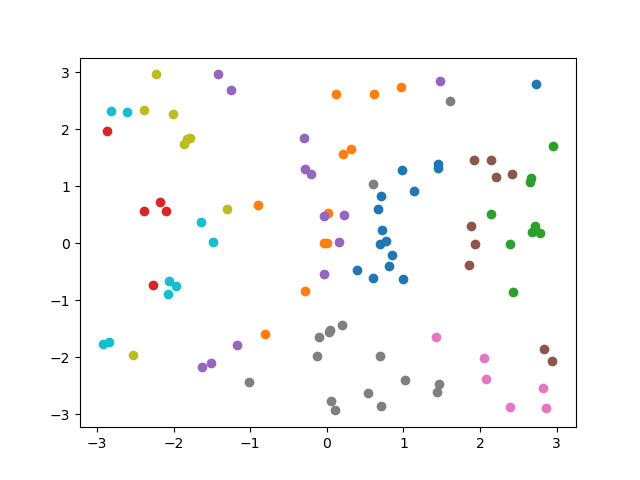

In [14]:
plt.figure()
for i in range(len(experiment.sample.x)):
    xis = experiment.sample.x[i].values
    yis = experiment.sample.y[i].values
    cis = 'C'+str(kmeans.labels_[i])
    plt.scatter(xis, yis, c=cis)